#  Projet Machine Learning

### Paul BOURCEREAU
[Github]()

## 1) Sujet

[Overall Survival Prediction for patients diagnosed with Myeloid Leukemia](https://challengedata.ens.fr/challenges/162)

### 1.1) Contexte

Problématique : comment prédire le risque de décès chez des patients atteints de leucémie ? 
L’objectif est d’estimer la survie globale de chaque patient à partir de leurs données cliniques (paramètres sanguins, anomalies chromosomiques, etc.) et moléculaires (mutations génétiques spécifiques). Les prédictions permettent d’identifier les patients à haut risque, pouvant nécessiter des traitements intensifs, et ceux à faible risque, pour lesquels des thérapies de soutien sont plus adaptées. Le modèle est évalué selon sa capacité à classer correctement les patients en fonction de leur risque de décès, en tenant compte de la censure liée aux patients toujours en vie au dernier suivi.

### 1.2) Description des données

#### **Variables explicatives**  

1. **Données cliniques** (une ligne par patient) :  
   - ID : Identifiant unique du patient.  
   - CENTER : Centre clinique de traitement.  
   - BM_BLAST : Pourcentage de blastes dans la moelle osseuse (cellules anormales).  
   - WBC : Nombre de globules blancs (en Giga/L).  
   - ANC : Nombre absolu de neutrophiles (en Giga/L).  
   - MONOCYTES : Nombre de monocytes (en Giga/L).  
   - HB : Taux d’hémoglobine (en g/dL).  
   - PLT : Nombre de plaquettes (en Giga/L).  
   - CYTOGENETICS : Description des anomalies chromosomiques (caryotype).  

2. **Données moléculaires** (plusieurs lignes possibles par patient) :  
   - ID : Identifiant unique du patient.  
   - CHR, START, END : Position de la mutation sur le génome.  
   - REF, ALT : Nucléotides de référence et alternatifs.  
   - GENE : Gène affecté.  
   - PROTEIN_CHANGE : Modification de la protéine.  
   - EFFECT : Type d’impact de la mutation sur la fonction du gène.  
   - VAF : Fraction allélique variante (proportion de cellules portant la mutation).  

#### **Variable cible**  

- **OS_YEARS** : Temps de survie global en années depuis le diagnostic.  
- **OS_STATUS** : État de survie (1 = Décès, 0 = Censuré, patient vivant au dernier suivi).  

**Objectif** : Prédire un **"risk_score"** représentant le risque de décès pour chaque patient.

### 1.3) Description du benchmark

### **Description du benchmark**  

Le benchmark utilise deux modèles pour prédire le risque de décès :  

1. **LightGBM (Gradient Boosting)** :  
   - Utilise uniquement les **données cliniques**.  
   - Ne prend pas en compte la censure des patients encore en vie.  
   - Modèle simple servant d'exemple de base.  

2. **Modèle de Cox (Risques Proportionnels)** :  
   - Exploite à la fois les **données cliniques** et certaines informations sur les **mutations génétiques**.  
   - Prend en compte la **censure à droite**, essentielle pour les données de survie.  
   - C’est le modèle utilisé pour établir le **score de référence** du challenge.  

## 2) Préparation des données

### 2.1) Importations des bibliothèques

In [1]:
import warnings
from scipy.linalg import LinAlgWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=LinAlgWarning)

# Import necessary libraries
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv

import plotly_express as px

### 2.2) Importation des données

##### Importation de nos tables en dataframe pandas

In [2]:
# Clinical Data
df = pd.read_csv("./X_train/clinical_train.csv")
df_eval = pd.read_csv("./X_test/clinical_test.csv")

# Molecular Data
maf_df = pd.read_csv("./X_train/molecular_train.csv")
maf_eval = pd.read_csv("./X_test/molecular_test.csv")

target_df = pd.read_csv("./target_train.csv")

##### Vérification des tailles des fichiers

In [3]:
print(f"Taille de df: {df.shape}")
print(f"Taille de df_eval: {df_eval.shape}")
print(f"Taille de maf_df: {maf_df.shape}")
print(f"Taille de maf_eval: {maf_eval.shape}")
print(f"Taille de target_df: {target_df.shape}")

Taille de df: (3323, 9)
Taille de df_eval: (1193, 9)
Taille de maf_df: (10935, 11)
Taille de maf_eval: (3089, 11)
Taille de target_df: (3323, 3)


### 2.3) Exploration des données 

#### Informations sur nos features + interprétation

Données clinique

In [4]:
import plotly.subplots as sp

numeric_columns = df.select_dtypes(include=['float64']).columns

fig = sp.make_subplots(rows=(len(numeric_columns) // 2) + 1, cols=2, subplot_titles=numeric_columns)

for i, column in enumerate(numeric_columns):
    row = (i // 2) + 1
    col = (i % 2) + 1
    fig.add_trace(px.violin(df, y=column, box=True, points="all").data[0], row=row, col=col)

fig.update_layout(height=1200, title_text="Distribution des features (Numériques)")
fig.show()

1. **BM_BLAST, WBC, ANC, MONOCYTES, PLT** : présentent des distributions asymétriques avec des valeurs extrêmes.

2. **HB** : Distribution plus symétrique mais présente quelques valeurs extrêmes.

In [5]:
numeric_columns = maf_df.select_dtypes(include=['float64']).columns

fig = sp.make_subplots(rows=(len(numeric_columns) // 2) + 1, cols=2, subplot_titles=numeric_columns)

for i, column in enumerate(numeric_columns):
    row = (i // 2) + 1
    col = (i % 2) + 1
    fig.add_trace(px.violin(maf_df, y=column, box=True, points="all").data[0], row=row, col=col)

fig.update_layout(height=1200, title_text="Distribution des features moléculaires (Numériques)")
fig.show()

1. **START** et **END** : Distributions similaires, avec des zones de forte concentration et d'autres de vide. 

2. **VAF** : Déjà normalisé, forte concentration en 0.44 et 0.06. 

3. **DEPTH** : Seulement quelques valeurs extrêmes

#### Corrélation entre les features et la cible

In [7]:
from scipy.stats import chi2_contingency

df_merged = pd.merge(df, target_df.dropna(), on='ID', how="right")

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))

def calculate_correlation(df, target_col):
    correlations = {}
    for col in df.columns:
        if df[col].dtype == 'object' or len(df[col].unique()) < 10:  
            confusion_matrix = pd.crosstab(df[col], df[target_col])
            correlations[col] = cramers_v(confusion_matrix.values)
        else: 
            correlations[col] = df[col].corr(df[target_col])
    return correlations

clinical_correlations = calculate_correlation(df_merged, 'OS_YEARS')

maf_merged = pd.merge(maf_df, target_df, on='ID')

molecular_correlations = calculate_correlation(maf_merged, 'OS_YEARS')

print("Corrélation des données cliniques avec OS_YEARS:")
print(pd.Series(clinical_correlations).sort_values(key=abs, ascending=False).iloc[3:])

print("\nCorrélation des données moléculaires avec OS_YEARS:")
print(pd.Series(molecular_correlations).sort_values(key=abs, ascending=False).iloc[3:])

Corrélation des données cliniques avec OS_YEARS:
CYTOGENETICS    0.714213
CENTER          0.713217
PLT             0.172017
BM_BLAST       -0.152849
HB              0.150318
MONOCYTES      -0.057137
WBC            -0.050260
ANC            -0.027190
dtype: float64

Corrélation des données moléculaires avec OS_YEARS:
PROTEIN_CHANGE    0.651171
EFFECT            0.430230
GENE              0.394776
CHR               0.393592
REF               0.376857
ALT               0.364589
END               0.104799
START             0.104799
VAF              -0.040912
DEPTH             0.010872
dtype: float64


On remarque surtout pour les données cliniques une forte corrélation des variables catégorielles CYTOGENETICS et CENTER (V de cramer > 0.7). 
La feature CYTOGENETICS incorpore possible beaucoup d'informations qu'il sera important d'extraire par la suite.

## 3) Traitement et création de nouvelles features

### 3.1) Ajout de nouvelles features et création TRAIN et TEST

##### Analyse de la feature "CYTOGENETICS"

In [7]:
df[["CYTOGENETICS"]].head(5)

,CYTOGENETICS
0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,"46,xx"
2,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


In [8]:
from processing import parse_cytogenetics
# Methode qui permet d'analyser cette colonne, compte le nombre d'anomalies, détecte les anomalies à risque, 
# la présence de translocation, deletion ou d'une monosomie
df = parse_cytogenetics(df)

In [9]:
CHR_LENGTH = {
  "1": 247249719,
  "2": 242951149,
  "3": 199501827,
  "4": 191273063,
  "5": 180857866,
  "6": 170899992,
  "7": 158821424,
  "8": 146274826,
  "9": 140273252,
  "10": 135374737,
  "11": 134452384,
  "12": 132349534,
  "13": 114142980,
  "14": 106368585,
  "15": 100338915,
  "16": 88827254,
  "17": 78774742,
  "18": 76117153,
  "19": 63811651,
  "20": 62435964,
  "21": 46944323,
  "22": 49691432,
  "X": 154913754,
  "Y": 57772954
}
maf_df["CHR_LENGTH"] = maf_df["CHR"].map(CHR_LENGTH)
maf_eval["CHR_LENGTH"] = maf_eval["CHR"].map(CHR_LENGTH)

In [10]:
from sksurv.util import Surv
target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)

X = df.loc[df['ID'].isin(target_df['ID'])]
y = target_df.set_index("ID")

In [11]:
# Séparation train/test
X_train_molecular, X_train, y_train_molecular, y_train = train_test_split(X, y, test_size=0.9, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [ ]:
from processing import process_molecular_data

# On garde uniquement les lignes des données moléculaires et variables cibles qui correspondent à celles dans X_train et X_test
maf_train = maf_df[maf_df["ID"].isin(X_train["ID"].unique())]
maf_test = maf_df[maf_df["ID"].isin(X_test["ID"].unique())]
target_train = target_df[target_df["ID"].isin(X_train["ID"].unique())]
target_test = target_df[target_df["ID"].isin(X_test["ID"].unique())]
maf_train_molecular = maf_df[maf_df["ID"].isin(X_train_molecular["ID"].unique())]
target_train_molecular = target_df[target_df["ID"].isin(X_train_molecular["ID"].unique())]

# Nous intégrons les données moléculaires en analysant et aggrégeant les statistiques basiques pour chaque features
processed_maf = process_molecular_data(maf_train, maf_train_molecular, target_train_molecular)
processed_maf_test = process_molecular_data(maf_test, maf_train_molecular, target_train_molecular)

X_train = X_train.merge(processed_maf, on="ID", how="left")
X_test = X_test.merge(processed_maf_test, on="ID", how="left")

X_train_id = X_train["ID"]
X_test_id = X_test["ID"]

for col in X_train.columns: 
    if col not in X_test.columns: 
        X_test[col] = 0
X_test = X_test[X_train.columns]

In [13]:
all_features = X_train.columns[2:]
X_train = X_train[all_features]
X_test = X_test[all_features]

### 4.2) Normalisation des données

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 4.3) Traitement des valeurs manquantes (Imputation)

In [15]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [54]:
# Initialisation du tableau regroupant les performances des modèles
model_results = []
def add_model_result(name, concordance_train, concordance_test):
    model_results.append({
        "Model": name,
        "Concordance Train": concordance_train,
        "Concordance Test": concordance_test
    })
    print(f"Model: {name}, Concordance Train: {concordance_train}, Concordance Test: {concordance_test}")

## 6) Benchmark

##### **Mesure de performance demandée par le challenge**

Nous adaptons également cette metrique pour qu'elle soit utilisable dans nos GridSearch au moment de l'optimisation de nos hyperparamètre.

In [16]:
target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)

target_df['OS_YEARS'] = pd.to_numeric(target_df['OS_YEARS'], errors='coerce')

target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(bool)

features = ['BM_BLAST', 'HB', 'PLT']
target = ['OS_YEARS', 'OS_STATUS']

X_bench = df.loc[df['ID'].isin(target_df['ID'])]

In [17]:
X_train_bench = X_bench.loc[X_bench['ID'].isin(X_train_id), features]
X_test_bench = X_bench.loc[X_bench['ID'].isin(X_test_id), features]
y_train_bench = target_df[target_df['ID'].isin(X_train_id)]
y_test_bench = target_df[target_df['ID'].isin(X_test_id)]

In [18]:
imputer = SimpleImputer(strategy="median")
X_train_bench[['BM_BLAST', 'HB', 'PLT']] = imputer.fit_transform(X_train_bench[['BM_BLAST', 'HB', 'PLT']])
X_test_bench[['BM_BLAST', 'HB', 'PLT']] = imputer.transform(X_test_bench[['BM_BLAST', 'HB', 'PLT']])

In [ ]:
from sklearn.metrics import make_scorer
from sksurv.metrics import concordance_index_ipcw

def score_method(y_test, y_pred): 
        # Simpe test pour gérer la forme de la variable cible 
        if type(y_test)==pd.DataFrame: 
            y_test = Surv.from_dataframe("OS_STATUS", "OS_YEARS", y_test)
        elif type(y_test)==pd.Series:
                y_test = Surv.from_dataframe("OS_STATUS", "OS_YEARS", y.loc[y_test.index])
        return concordance_index_ipcw(Surv.from_dataframe("OS_STATUS", "OS_YEARS", y_train), y_test, y_pred, tau=7)[0]

custom_score = make_scorer(score_method, greater_is_better=True)

In [20]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

##### **Création et Entrainement du modèle**

In [ ]:
import sklearn as sk
param_grid = {
    'alpha': [0, 0.5, 1, 2, 5],
    'ties': ['efron', 'breslow'],
}

# Configuration de la recherche en grille avec validation croisée
grid_search = sk.model_selection.GridSearchCV(CoxPHSurvivalAnalysis(), param_grid=param_grid, scoring=custom_score, cv=3, n_jobs=None, verbose=0)
grid_search.fit(X_train_bench, Surv.from_dataframe("OS_STATUS", "OS_YEARS", y_train_bench))

# Meilleur modèle et paramètres
baseline_model = grid_search.best_estimator_
print("Meilleur modèle:", baseline_model.get_params())

Meilleur modèle: {'alpha': 0, 'n_iter': 100, 'ties': 'efron', 'tol': 1e-09, 'verbose': 0}


In [55]:
concordance_baseline_train = score_method(y_train_bench, baseline_model.predict(X_train_bench))
concordance_baseline_test = score_method(y_test_bench, baseline_model.predict(X_test_bench))
add_model_result("Baseline", concordance_baseline_train, concordance_baseline_test)

Model: Baseline, Concordance Train: 0.6580284574308736, Concordance Test: 0.6723306894561297


Nous obtenons des résultats similaire à celui du benchmark

## 7) Modèle supervisé

Tests des modèles classiques

In [23]:
y_train["OS_YEARS"] = np.maximum(y_train["OS_YEARS"], 0.0001)

In [24]:
from sksurv.linear_model import (
    CoxPHSurvivalAnalysis,
    CoxnetSurvivalAnalysis
)
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.svm import FastSurvivalSVM

from xgboost import XGBRegressor
import lightgbm as lgb

In [ ]:
# Nous testons plusieurs modèles de régression
# XGBoost, LightGBM, Ridge, Lasso, SVM
models = {
    'XGBoost' : XGBRegressor(**{
        "objective": "survival:cox",
        "n_estimators": 50
    }),
    'LightGBM' : lgb.LGBMRegressor(**{
        'objective':"poisson",
        'verbose': -1,
        'n_estimators': 50,
    }),
    'Ridge Regression': CoxnetSurvivalAnalysis(l1_ratio=0.0001),
    'Lasso Regression': CoxnetSurvivalAnalysis(l1_ratio=1),
    'SVM': FastSurvivalSVM(alpha=0.1),
}

res = list()

for model in models.values() :
    
    def score_method(y_test, y_pred): 
        if type(model)==lgb.LGBMRegressor:
            y_pred *= -1
        if type(y_test)==pd.DataFrame: 
            y_test = Surv.from_dataframe("OS_STATUS", "OS_YEARS", y_test)
        elif type(y_test)==pd.Series:
            y_test = Surv.from_dataframe("OS_STATUS", "OS_YEARS", y.loc[y_test.index])
        return concordance_index_ipcw(Surv.from_dataframe("OS_STATUS", "OS_YEARS", y_train), y_test, y_pred, tau=7)[0]

    custom_score = make_scorer(score_method, greater_is_better=True)
    
    if type(model)==lgb.LGBMRegressor or type(model)==XGBRegressor:
        y_model = y_train["OS_YEARS"]
    else: 
        y_model = Surv.from_dataframe("OS_STATUS", "OS_YEARS", y_train)
        
    model.fit(X_train, y_model)
    # Évaluation du modèle
    cv_scores = sk.model_selection.cross_val_score(model, X_train, y_model, cv=5, scoring=custom_score, n_jobs=None, verbose=0)
    res.append([model.__class__.__name__,cv_scores])
    add_model_result(model.__class__.__name__, cv_scores.mean(), score_method(y_test, model.predict(X_test)))

Model: XGBRegressor, Concordance Train: 0.6446022138406808, Concordance Test: 0.6634711077458304
Model: LGBMRegressor, Concordance Train: 0.6677066330061904, Concordance Test: 0.7079549095950469
Model: CoxnetSurvivalAnalysis, Concordance Train: 0.6779769553057385, Concordance Test: 0.6957619884466034
Model: CoxnetSurvivalAnalysis, Concordance Train: 0.6886140963708373, Concordance Test: 0.709172404458405
Model: FastSurvivalSVM, Concordance Train: 0.6933046404165422, Concordance Test: 0.713552874508618


On remarque que le modèle le plus performant (sur les sets de train et test) est le FastSurvivalSVM, basé sur un modèle de Support Vector Machine adapté à notre type de problème. 
Nous allons donc explorer ce modèle plus en détails et optimiser ses paramètres pour obtenir les meilleurs performances possibles. 

#### Fine tuning du modèle

In [70]:
import sklearn as sk
param_grid = {
    'alpha': [0, 0.5, 1],
    'optimizer': ['avltree', 'rbtree']
}

# Configuration de la recherche en grille avec validation croisée
grid_search = sk.model_selection.GridSearchCV(FastSurvivalSVM(), param_grid=param_grid, scoring=custom_score, cv=3, n_jobs=None, verbose=1)
grid_search.fit(X_train, Surv.from_dataframe("OS_STATUS", "OS_YEARS", y_train))

# Meilleur modèle et paramètres
best_model = grid_search.best_estimator_
print("Meilleur modèle:", best_model.get_params())

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:1103: UserWarning:

One or more of the test scores are non-finite: [       nan        nan 0.69172937 0.69172526 0.69164391 0.69165218]



Meilleur modèle: {'alpha': 0.5, 'fit_intercept': False, 'max_iter': 20, 'optimizer': 'avltree', 'random_state': None, 'rank_ratio': 1.0, 'timeit': False, 'tol': None, 'verbose': False}


In [71]:
add_model_result("SVM FineTuned", score_method(y_train, best_model.predict(X_train)), score_method(y_test, best_model.predict(X_test)))

Model: SVM FineTuned, Concordance Train: 0.7109636643657645, Concordance Test: 0.7134000394880516


Notre modèle est maintenant meilleur que le modèle de référence, d'environ 6% 

## 7) Modèle non supervisé 

Une difficulté de ce sujet est de correctement intégrer les "données moléculaires" des patients dans notre modèle car un patient peut avoir plusieurs lignes associées. La solution utilisée jusqu'à présent était d'aggréger les différentes lignes en une seule, en calculant des statistiques classiques (moyenne, var etc...) pour chaque feature. 
Des méthodes de machine learning non supervisé pourrait être utile ici, en détectant des caractéristiques particulières qui pourraient être plus facilement intégrable au jeu de donnée cliniques. Nous allons notamment utiliser des méthodes de clustering pour identifier de possibles clusters dans les échantillons, et pour chaque patient compter la proportion de données moléculaires appartenant à chaque clusters. 

In [72]:
molecular_train = maf_df[maf_df["ID"].isin(X_train_id)].dropna().set_index("ID").drop(columns=["GENE", "PROTEIN_CHANGE"])

Ici nous allons transformer les variables categorielles en numériques par un one hot encoding

Nous avons décidé de ne garder que les features avec les plus grandes variances, de sorte à filtrer les dummies encodant moins d'informations

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import explained_variance_score

string_columns = molecular_train.select_dtypes(include=['object']).columns

preprocess_pipe = Pipeline([
    ('one_hot_encoding', ColumnTransformer(
        transformers=[
            ('one_hot', OneHotEncoder(drop='first', dtype=int, sparse_output=False, handle_unknown="ignore"), string_columns)
        ],
        remainder='passthrough'
    )),
    ('variance_threshold', VarianceThreshold(0.0005)),  
    ('scaling', StandardScaler()),
])

preprocessed = pd.DataFrame(preprocess_pipe.fit_transform(molecular_train))

In [74]:
molecular_train_target = molecular_train.merge(target_df, on="ID", how="left")
molecular_train_target["OS_YEARS"] = np.maximum(molecular_train_target["OS_YEARS"], 0.0001)
molecular_train_target = Surv.from_dataframe("OS_STATUS", "OS_YEARS",molecular_train_target)

In [75]:
pca = PCA(n_components=5)
reduced_pca = pca.fit_transform(preprocessed)

Pour tester simplement la pertinence de cette méthode, nous regardons si le dataset à dimension réduites permet de prédire la variable cible. Nous utilisons ici notre modèle benchmark pour comparer les performances. 

In [76]:
concordance_index_ipcw(molecular_train_target, molecular_train_target, CoxPHSurvivalAnalysis().fit(reduced_pca, molecular_train_target).predict(reduced_pca))[0]

0.5576371181123349

##### Deep Learning

Nous avons choisi d'implémenter un modèle de deep learning dans ce contexte de réduction de dimension, en espérant obtenir de meilleurs résultats qu'avec un simple ACP. Nous avons implémenté un auto-encoder dont le but est de créer une représentation à faible dimension de notre input, et à partir de celle-ci recréer l'input à l'identique. 
La représentation à faible dimension pourra ensuite être extraite pour être comparé avec celle résultante de l'ACP. 

In [78]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses

input_dim = preprocessed.shape[1]

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(128, activation='relu')(input_layer)
encoded = layers.Dropout(0.2)(encoded) # Un dropout est ajouté pour éviter le surapprentissage
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(5, activation='sigmoid')(encoded) # L'activation sigmoid est utilisée pour assurer que les valeurs soient bornées 

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(input_dim)(decoded)

encoder = models.Model(input_layer, encoded)
autoencoder = models.Model(input_layer, decoded)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [85]:
# Nous ajoutons un callback d'early stopping pour éviter le surapprentissage, et nous arrêtons l'entraînement si la loss ne s'améliore pas pendant 10 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      
    patience=10,              
    restore_best_weights=True
)

history = autoencoder.fit(
    preprocessed, preprocessed,
    epochs=500,
    batch_size=8,
    shuffle=True,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/500
660/660 [==============================] - 3s 2ms/step - loss: 0.8853 - val_loss: 1.0845
Epoch 2/500
660/660 [==============================] - 1s 2ms/step - loss: 0.8168 - val_loss: 1.0445
Epoch 3/500
660/660 [==============================] - 2s 3ms/step - loss: 0.7768 - val_loss: 1.0108
Epoch 4/500
660/660 [==============================] - 2s 2ms/step - loss: 0.7456 - val_loss: 0.9785
Epoch 5/500
660/660 [==============================] - 1s 2ms/step - loss: 0.7201 - val_loss: 0.9549
Epoch 6/500
660/660 [==============================] - 1s 2ms/step - loss: 0.6946 - val_loss: 0.9295
Epoch 7/500
660/660 [==============================] - 1s 2ms/step - loss: 0.6710 - val_loss: 0.8997
Epoch 8/500
660/660 [==============================] - 1s 2ms/step - loss: 0.6499 - val_loss: 0.8830
Epoch 9/500
660/660 [==============================] - 1s 2ms/step - loss: 0.6363 - val_loss: 0.8591
Epoch 10/500
660/660 [==============================] - 1s 2ms/step - loss: 0.6198 - val_lo

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Il n'est pas évident d'interpréter directement la valeur de la loss, mais nous remarquons que celle-ci décroit raisonnablement pour les données d'entrainement et de validation. 
Il semble donc que le modèle converge vers une solution optimale et ne sur-apprend pas trop. 

In [79]:
reduced_deep = encoder.predict(preprocessed)

207/207 [==============================] - 0s 925us/step


In [80]:
concordance_index_ipcw(molecular_train_target, molecular_train_target, CoxPHSurvivalAnalysis().fit(reduced_deep, molecular_train_target).predict(reduced_deep))[0]

0.516637710698667

Toutefois le test de performance sur la variable cible donne un moins bon résultat qu'avec l'ACP, il peut malgré tout être pertinent à utiliser. 

Pour réellement évaluer les deux méthodes de réductions de la dimensionnalité, nous allons procéder au clustering et voir quelle méthode permet d'obtenir les meilleurs résultats

##### Clustering

In [81]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

Nous testons d'abord la méthode KMeans, avec plusieurs nombres de clusters

In [82]:
silhouette_scores_pca = []
silhouette_scores_deep = []
k_values = range(2, 20)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)  
    silhouette_avg_pca = silhouette_score(reduced_pca, kmeans.fit_predict(reduced_pca))
    silhouette_scores_pca.append(silhouette_avg_pca)
    silhouette_avg_deep = silhouette_score(reduced_deep, kmeans.fit_predict(reduced_deep))
    silhouette_scores_deep.append(silhouette_avg_deep)
    print(f"Pour n_clusters = {k}: silhouette score pca = {silhouette_avg_pca:.3f}, silhouette score deep = {silhouette_avg_deep:.3f}")

Pour n_clusters = 2: silhouette score pca = 0.204, silhouette score deep = 0.486
Pour n_clusters = 3: silhouette score pca = 0.226, silhouette score deep = 0.182
Pour n_clusters = 4: silhouette score pca = 0.268, silhouette score deep = 0.174
Pour n_clusters = 5: silhouette score pca = 0.285, silhouette score deep = 0.174
Pour n_clusters = 6: silhouette score pca = 0.277, silhouette score deep = 0.180
Pour n_clusters = 7: silhouette score pca = 0.302, silhouette score deep = 0.184
Pour n_clusters = 8: silhouette score pca = 0.316, silhouette score deep = 0.170
Pour n_clusters = 9: silhouette score pca = 0.315, silhouette score deep = 0.174
Pour n_clusters = 10: silhouette score pca = 0.327, silhouette score deep = 0.178
Pour n_clusters = 11: silhouette score pca = 0.322, silhouette score deep = 0.176
Pour n_clusters = 12: silhouette score pca = 0.319, silhouette score deep = 0.183
Pour n_clusters = 13: silhouette score pca = 0.316, silhouette score deep = 0.183
Pour n_clusters = 14: si

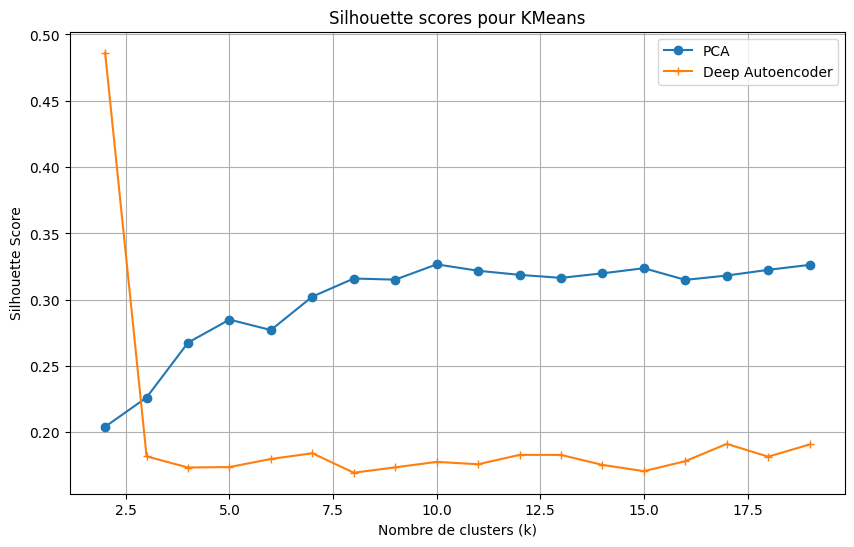

Nombre de cluster optimal après PCA : 10
Nombre de cluster optimal après Deep Autoencoder : 2


In [83]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores_pca, 'o-')
plt.plot(k_values, silhouette_scores_deep, '+-')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette scores pour KMeans')
plt.legend(['PCA', 'Deep Autoencoder'])
plt.grid(True)
plt.show()

optimal_k_pca = k_values[np.argmax(silhouette_scores_pca)]
print(f"Nombre de cluster optimal après PCA : {optimal_k_pca}")
optimal_k_deep = k_values[np.argmax(silhouette_scores_deep)]
print(f"Nombre de cluster optimal après Deep Autoencoder : {optimal_k_deep}")

On remarque que le silhouette score augmente avec le nombre clusters, ce qui n'est généralement pas bon signe. 
Il est possible que nos données ne présentent pas vraiment de structure en cluster, ou que la dimensionnalité (5) soit toujours trop élevée et fausse la mesure de distance des échantillons. 

La deuxième méthode que nous allons tester est DBScan, qui est plus robuste aux outliers et au bruit. 

In [ ]:
eps_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]
min_samples_values = [5, 10, 20, 40]

best_score = -1
best_eps = None
best_min_samples = None
best_n_clusters = 0
base_name = "PCA"

silhouette_scores = {
    "PCA": [],
    "Deep": []
}

for reduced, name in [(reduced_pca, "PCA"), (reduced_deep, "Deep")]:
    print(f"\nDBSCAN clustering pour les features {name} :")
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_labels = dbscan.fit_predict(reduced)
            if (dbscan_labels != -1).sum() > 1:
                clustered_data = reduced[dbscan_labels != -1]
                clustered_labels = dbscan_labels[dbscan_labels != -1]
                if len(np.unique(clustered_labels)) <= 1:
                    continue
                score = silhouette_score(clustered_data, clustered_labels)
                silhouette_scores[name].append(score)
                print(f"DBSCAN: eps={eps}, min_samples={min_samples}, silhouette score={score:.3f}")
                n_clusters = len(np.unique(dbscan_labels[dbscan_labels != -1]))
                if score > best_score:
                    best_score, best_eps, best_min_samples, best_n_clusters, best_name = score, eps, min_samples, n_clusters, name

print(f"\nBest DBSCAN parameters: eps={best_eps}, min_samples={best_min_samples}, dataset={best_name}")
print(f"Silhouette score: {best_score:.3f}")
print(f"Number of clusters: {best_n_clusters}")


DBSCAN clustering for PCA features:
DBSCAN: eps=0.1, min_samples=5, silhouette score=0.705
DBSCAN: eps=0.1, min_samples=10, silhouette score=0.800
DBSCAN: eps=0.1, min_samples=20, silhouette score=0.864
DBSCAN: eps=0.1, min_samples=40, silhouette score=0.974
DBSCAN: eps=0.3, min_samples=5, silhouette score=0.601
DBSCAN: eps=0.3, min_samples=10, silhouette score=0.662
DBSCAN: eps=0.3, min_samples=20, silhouette score=0.771
DBSCAN: eps=0.3, min_samples=40, silhouette score=0.794
DBSCAN: eps=0.5, min_samples=5, silhouette score=0.473
DBSCAN: eps=0.5, min_samples=10, silhouette score=0.544
DBSCAN: eps=0.5, min_samples=20, silhouette score=0.650
DBSCAN: eps=0.5, min_samples=40, silhouette score=0.752
DBSCAN: eps=0.7, min_samples=5, silhouette score=-0.031
DBSCAN: eps=0.7, min_samples=10, silhouette score=0.143
DBSCAN: eps=0.7, min_samples=20, silhouette score=0.310
DBSCAN: eps=0.7, min_samples=40, silhouette score=0.544
DBSCAN: eps=0.9, min_samples=5, silhouette score=-0.205
DBSCAN: eps=0.

DBSCAN obtient de meilleur silhouettes scores mais pour la plupart les clusters sont très petits et rapprochés. Nous choisissons plutôt le clustering de KMeans qui semble pouvoir mieux généraliser. Enfin les silhouettes score de KMeans sont comparables pour les données issues du PCA et de l'autoencoder, mais par parcimonie nous choisissons la méthode PCA, plus simple, et qui propose un bon score pour 10 clusters.

In [39]:
optimal_clustering = KMeans(n_clusters=10)
reduced_pca = pd.DataFrame(reduced_pca)
reduced_pca["Cluster"] = optimal_clustering.fit_predict(reduced_pca)

In [378]:
fig = px.scatter_3d(
    reduced_pca, 
    x=0, 
    y=1, 
    z=2, 
    color='Cluster',
    title='Clustering KMeans sur les données moléculaires',
    labels={'0': 'ACP_1', '1': 'ACP_2', '2': 'ACP_3'},
    opacity=0.7
)

fig.update_layout(
    legend_title_text='Cluster',
    scene=dict(
        xaxis_title='ACP_1',
        yaxis_title='ACP_2',
        zaxis_title='ACP_3'
    )
)

fig.show()

# Répartition des clusters

cluster_counts = reduced_pca['Cluster'].value_counts().sort_index()
cluster_percentages = 100 * cluster_counts / len(reduced_pca)

fig2 = px.bar(
    x=cluster_counts.index,
    y=cluster_percentages,
    labels={'x': 'Cluster', 'y': 'Pourcentage (%)'},
    title='Distribution des clusters',
    text=cluster_percentages.round(1)
)

fig2.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig2.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig2.show()

On remarque que le nuage de points est correctement séparé en plusieurs clusters. Ceux ci sont répartis à peu près équitablement, sauf pour le cluster 4 qui comprend les points éloignés du nuage, de possibles outliers. 

##### Prévisions avec dataset amélioré

In [90]:
molecular_train = maf_df[maf_df["ID"].isin(X_train_id)].dropna().set_index("ID").drop(columns=["GENE", "PROTEIN_CHANGE"])
molecular_test = maf_df[maf_df["ID"].isin(X_test_id)].dropna().set_index("ID").drop(columns=["GENE", "PROTEIN_CHANGE"])

trans_molecular_train = pd.DataFrame(pca.transform(preprocess_pipe.transform(molecular_train)))
trans_molecular_test = pd.DataFrame(pca.transform(preprocess_pipe.transform(molecular_test)))

In [91]:
train_cluster = pd.DataFrame(optimal_clustering.predict(trans_molecular_train), index=molecular_train.index, columns=["Cluster"])
test_cluster = pd.DataFrame(optimal_clustering.predict(trans_molecular_test), index=molecular_test.index, columns=["Cluster"])

In [92]:
mol_train = train_cluster.groupby(train_cluster.index).apply(lambda x: x.value_counts(normalize=True)).unstack().fillna(0).add_prefix("Cluster_")
mol_test = test_cluster.groupby(test_cluster.index).apply(lambda x: x.value_counts(normalize=True)).unstack().fillna(0).add_prefix("Cluster_")

In [93]:
X_train_aug = pd.DataFrame(X_train, index=X_train_id).add_prefix("og_").merge(mol_train, on="ID", how="left")
X_test_aug = pd.DataFrame(X_test, index=X_test_id).add_prefix("og_").merge(mol_test, on="ID", how="left")

In [94]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

X_train_aug = imputer.fit_transform(X_train_aug)
X_test_aug = imputer.transform(X_test_aug)

In [95]:
best_model.fit(X_train_aug, Surv.from_dataframe("OS_STATUS", "OS_YEARS", y_train))

FastSurvivalSVM(alpha=0.5, optimizer='avltree')

In [97]:
pred_train_aug = best_model.predict(X_train_aug)
pred_test_aug = best_model.predict(X_test_aug)
add_model_result("SVM + Learnt Features", score_method(y_train, pred_train_aug), score_method(y_test, pred_test_aug))

Model: SVM + Learnt Features, Concordance Train: 0.7126906894506799, Concordance Test: 0.7083966807786832


On remarque que la performance sur les données d'entrainement est meilleure que notre best_model, mais moins bonne sur les données de test. Cela peut donc révéler qu'un sur apprentissage a été fait sur les données générées par l'ACP et le clustering. 

### 7.3) Modèle d'ensemble

Nous allons maintenant combiner les différents modèles que nous avons testés précedemment dans un unique modèle d'ensemble. Nous implémentons un VotingRegressor, dans lequel les estimations des différents modèles seront utilisées pour faire une prédiction finale.  

**Creation du modèle**

In [99]:
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.base import is_regressor
import numpy as np

class VotingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, estimators, weights=None):
        self.estimators = estimators
        self.weights = weights

    def fit(self, X, y):
        self.estimators_ = [(name, clone(est)) for name, est in self.estimators]
        for _, estimator in self.estimators_:
            if is_regressor(estimator):  # scikit-learn estimator
                y_target = y["OS_YEARS"]
                estimator.fit(X, y_target)
            else: # sksurv estimator
                y_target = Surv.from_dataframe("OS_STATUS", "OS_YEARS", y)
                estimator.fit(X, y_target)
        return self

    def predict(self, X):
        predictions = []
        for _, estimator in self.estimators_:
            predictions.append(estimator.predict(X))
        predictions = np.array(predictions)
        
        if self.weights is not None:
            weighted_predictions = np.average(predictions, axis=0, weights=self.weights)
            return weighted_predictions
        else:
            return np.mean(predictions, axis=0)
        

In [ ]:
models = {
    'XGBoost' : XGBRegressor(**{
        "objective": "survival:cox",
        "n_estimators": 1000,    
        "eta": 0.001, 
        "max_depth": 4,  
        "subsample": 0.8,  
        "colsample_bytree": 0.95,  
    }),
    'Coxnet': CoxnetSurvivalAnalysis(l1_ratio=1),
    'SVM': FastSurvivalSVM(alpha=0.1),
}

voting_reg = VotingRegressor(
    estimators=list(models.items()),
    weights=[0.4, 0.1, 0.6]
)

In [101]:
voting_reg.fit(X_train,y_train)

VotingRegressor(estimators=[('XGBoost',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.95, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False, eta=0.001,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=4,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=1000, n_jobs=None,
                                          num_parallel_tree=None, ...)),
                            ('Coxnet', CoxnetSurvivalAnalysis(l1_ratio=1)),
                            ('SVM', FastSurvivalSVM(alpha=0.1))],
                weights=[0.4, 0.1, 0.6])

In [103]:
add_model_result("Voting Regressor", score_method(y_train, voting_reg.predict(X_train)), score_method(y_test, voting_reg.predict(X_test)))

Model: Voting Regressor, Concordance Train: 0.7280269627693315, Concordance Test: 0.7207303970470038


Ici nous observons de meilleures performance à la fois sur les données d'entrainement et de test, traduisant de meilleures performances en combinant les modèles.

**Optimisation des hyperparamètre**

In [ ]:
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.model_selection import KFold

# Définir l'espace des hyperparamètres à explorer pour chaque modèle
# (Plus de paramètres auraient pu être optimisés mais le temps d'exécution croit exponentiellement)
param_grid = {
    (0,'max_depth'): [4, 10, None],             
    (1, 'l1_ratio'): [0.1, 0.5, 1],    
    (2, 'alpha'): [0.1, 0.5, 1] 
}

# On choisit de séparer nos données en 5 sous ensembles
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_score = -1
best_params = None

# Parcourir toutes les combinaisons d'hyperparamètres
# Ici nous ne pouvons pas utiliser GridSearchCV car il ne supporte pas les modèles de scikit-surv
# On utilise donc une boucle pour parcourir manuellement les combinaisons
for params in ParameterGrid(param_grid):
    
    print(f"Testing parameters: {params}")
    
    for param in params.items():
        voting_reg.estimators[param[0][0]][1].set_params(**{param[0][1]: param[1]})
        
    scores = []
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        voting_reg.fit(X_train_fold, y_train_fold)
        y_pred_fold = voting_reg.predict(X_val_fold)
        scores.append(score_method(y_val_fold, y_pred_fold))
    
    mean_score = np.mean(scores)
    print(f"Mean score: {mean_score}")
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

grid_search = {"best_params": best_params, "best_score": best_score}

In [ ]:
grid_search["best_params"]

{(0, 'max_depth'): 10, (1, 'l1_ratio'): 1, (2, 'alpha'): 1}

In [104]:
# On implémente le modèle avec les meilleurs hyperparamètres
models = {
    'XGBoost' : XGBRegressor(**{
        "objective": "survival:cox",
        "n_estimators": 1000,    
        "eta": 0.001,  # Learning rate
        "max_depth": 10,  # Tree depth
        "subsample": 0.8,  # Subsample for boosting
        "colsample_bytree": 0.95,  # Feature selection
    }),
    'Coxnet': CoxnetSurvivalAnalysis(l1_ratio=1),
    'SVM': FastSurvivalSVM(alpha=1),
}

best_voting = VotingRegressor(
    estimators=list(models.items()),
    weights=[0.4, 0.1, 0.6]
)

In [105]:
best_voting.fit(X_train,y_train)
add_model_result("Voting Regressor FineTuned", score_method(y_train, best_voting.predict(X_train)), score_method(y_test, best_voting.predict(X_test)))

Model: Voting Regressor FineTuned, Concordance Train: 0.798332048916341, Concordance Test: 0.7226463908911072


La méthode d'ensemble permet d'améliorer drastiquement les résultats sur le jeu d'entrainement, et légèrement pour la partie de test. Un léger sur-apprentissage est possible.  Nous allons maintenant tenter d'interpréter notre modèle

**Interpretation de l'importances des variables explicatives**

In [113]:
# Calcule des features importances grâce à la méthode de permutation 
from sklearn.inspection import permutation_importance

def scoring(est, X, y):
    return concordance_index_ipcw(Surv.from_dataframe("OS_STATUS", "OS_YEARS", y), Surv.from_dataframe("OS_STATUS", "OS_YEARS", y), est.predict(X))[0]

result = permutation_importance(
    best_voting, X_train, y_train, n_repeats=5, random_state=1, n_jobs=-1, scoring=scoring
)

In [ ]:
importance_df = pd.DataFrame({
    "Feature": all_features,
    "Mean Importance": result.importances_mean,
    "Std Importance": result.importances_std
}).sort_values(by="Mean Importance", ascending=False)

fig = px.bar(
    importance_df, 
    x="Feature", 
    y="Mean Importance", 
    error_y="Std Importance", 
    title="Permutation Importance", 
    labels={"Feature": "Features", "Mean Importance": "Mean Importance"},
    height=600
)
fig.show()

La permutation importance permet de mesurer pour chaque feature la dégradation de notre metric lorsque les valeurs de cette feature sont aléatoirement redistribuées. 
On remarque donc que les variables les plus importantes ici sont : 
1. **PLT** : Le nombre de plaquette sanguines par litre de sang
2. **HB** : Le niveau d'hémoglobine dans le sang du patient  
4. **BM_BLAST** : La proportion de cellule sanguine anormales dans la moëlle épinière du patient 

Les 3, 5 et 6ème features les plus importantes sont liées à la position des anomalies sur leur chromosome, issues du jeu de données moléculaires. 

**Interpretation détaillée**

Pour procéder a une interprétation plus détaillée des résultats, nous nous intéressons aux Shap values. 

In [117]:
import shap
shap.initjs()

On appplique shap.kmeans sur notre dataset pour "résumer" le jeu de données et faciliter le calcul des valeurs de shap. 

In [118]:
X_train_summary = shap.kmeans(X_train, 10)

In [119]:
ex = shap.KernelExplainer(best_voting.predict, X_train_summary)

In [124]:
shap_values = ex.shap_values(X_test, nsamples=100)

  0%|          | 0/857 [00:00<?, ?it/s]

In [125]:
shap_values = shap_values.clip(min=-1, max=1) # on clip les valeurs car un unique point posait problème et empechait une bonne visualisation 

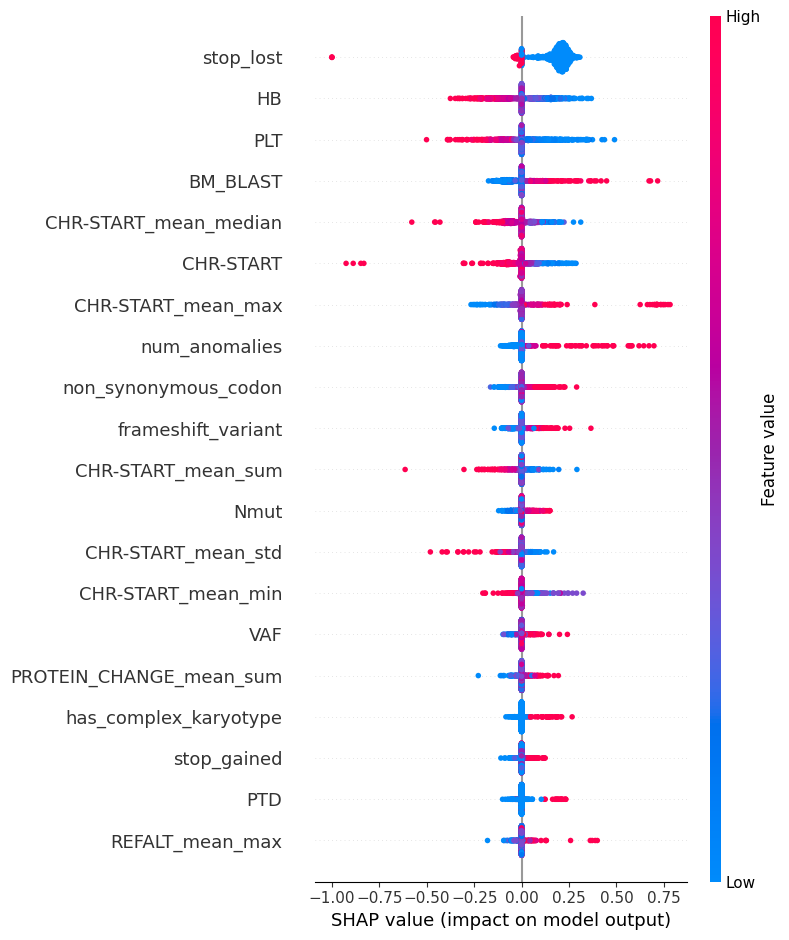

In [126]:
shap.summary_plot(shap_values, X_test, feature_names=all_features)

Ici on s'intéresse à l'impact de chaque features sur la prévision du modèle. On remarque notamment qu'un taux d'hémoglobine (HB) élevé a un effet positif sur la survie du patient, alors qu'un nombre élevé d'anomalies ou de mutations génétiques aura un effet plus néfaste sur le temps de survie du patient. 

## 10) Comparaison des résultats

In [131]:
pd.DataFrame(model_results).drop_duplicates(subset=["Model"], keep="last")

,Model,Concordance Train,Concordance Test
0,Baseline,0.658028,0.672331
11,XGBRegressor,0.644602,0.663471
12,LGBMRegressor,0.667707,0.707955
14,CoxnetSurvivalAnalysis,0.688614,0.709172
15,FastSurvivalSVM,0.693305,0.713553
16,SVM FineTuned,0.710964,0.713400
17,SVM + Learnt Features,0.712691,0.708397
18,Voting Regressor,0.728027,0.720730
19,Voting Regressor FineTuned,0.798332,0.722646


Le modèle benchmark proposé par QRT permettait déjà d'obtenir des résultats pertinents. Nous avons testés ensuite différents modèles, certains basés sur des arbres de décisions, d'autres dont la force était d'être adaptée à notre problématique de modélisation de temps de survie. 
Tous les modèles présentent des performances relativement similaires, mais nous avons pu en identifier un basé sur les SVM donnant de meilleurs résultats que nous avons pu encore plus améliorer en le fine-tunant correctement. 
Nous avons implémenté des méthodes d'unsupervised learning pour mieux prendre en compte les données moléculaires des patients, mais les résultats montrent plutôt que nos modèles ont eu tendance à overfitter dessus. 
Enfin nous avons créé un modèle basé sur l'aggrégation de sous modèles, dont les performances étaient meilleures, encore plus après son fine tuning. 
Finalement nous avons pu explorer l'importance et le rôle de nos features dans la prédiction de ce modèle, et observé qu'elles étaient plutôt en accord avec l'intuition biologique sous-jacente. 